In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("lbquctrung/worksite-safety-monitoring-dataset")

print("Path to dataset files:", path)

In [ ]:
import os
from pathlib import Path
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [ ]:
train_dir = '/kaggle/input/worksite-safety-monitoring-dataset/Worksite-Safety-Monitoring-Dataset/train'
test_dir = '/kaggle/input/worksite-safety-monitoring-dataset/Worksite-Safety-Monitoring-Dataset/test'
valid_dir = '/kaggle/input/worksite-safety-monitoring-dataset/Worksite-Safety-Monitoring-Dataset/valid'

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import json
import os
import numpy as np
import cv2

In [ ]:
train_datagen_noscale = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.05,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=[0.85, 1.15],
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen_noscale = ImageDataGenerator()
valid_datagen_noscale = ImageDataGenerator()

In [ ]:
def build_resnet_model(input_shape=(224, 224, 3)):
    base_model = tf.keras.applications.ResNet50(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape
    )
    base_model.trainable = False

    inputs = tf.keras.Input(shape=input_shape)
    x = tf.keras.applications.resnet50.preprocess_input(inputs)
    x = base_model(x, training=False)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    # x = tf.keras.layers.Dense(128, activation='relu')(x)
    # x = tf.keras.layers.BatchNormalization()(x)  # Tambahkan BN juga
    x = tf.keras.layers.Dropout(0.5)(x)
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

    model = tf.keras.Model(inputs, outputs)
    return model

results_resnet = {}

configs = [
  {"epoch": 15, "batch_size": 32, "lr": 5e-5},
    {"epoch": 15, "batch_size": 32, "lr": 1e-4}
]

for config in configs:
    print(f"Training: Epoch={config['epoch']}, LR={config['lr']}, Batch={config['batch_size']}")

    model = build_resnet_model()
    opt = tf.keras.optimizers.Adam(learning_rate=config["lr"])

    model.compile(optimizer=opt, loss="binary_crossentropy", metrics=["accuracy"])

    print(f"\n===== MODEL SUMMARY =====")
    model.summary()

    early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    train_generator = train_datagen_noscale.flow_from_directory(
        train_dir,
        target_size=(224, 224),
        batch_size=config['batch_size'],
        class_mode='binary',
        color_mode="rgb",
        shuffle=True
    )

    valid_generator = valid_datagen_noscale.flow_from_directory(
        valid_dir,
        target_size=(224, 224),
        batch_size=config['batch_size'],
        class_mode='binary',
        color_mode="rgb",
        shuffle=True
    )

    history = model.fit(train_generator,validation_data=valid_generator,epochs=config['epoch'],callbacks=[early_stop])
    results_resnet[(f"Training: Epoch={config['epoch']}, LR={config['lr']}, Batch={config['batch_size']}")] = history

Training: Epoch=15, LR=5e-05, Batch=32
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step

===== MODEL SUMMARY =====


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 224, 224)  │          0 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, 224, 224)  │          0 │ input_layer_1[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_2          │ (None, 224, 224)  │          0 │ input_layer_1[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack (Stack)       │ (None, 224, 224,  │          0 │ get_item[0][0],   │
│                     │ 3)                │            │ get_item_1[0][0], │
│                     │                   │            │ get_item_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 224, 224,  │          0 │ stack[0][0]       │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50            │ (None, 7, 7,      │ 23,587,712 │ add[0][0]         │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ resnet50[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │    524,544 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256)       │      1,024 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │        257 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 24,113,537 (91.99 MB)

 Trainable params: 525,313 (2.00 MB)

 Non-trainable params: 23,588,224 (89.98 MB)

Found 1620 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Epoch 1/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 62s 926ms/step - accuracy: 0.5345 - loss: 0.9042 - val_accuracy: 0.5950 - val_loss: 0.7937
Epoch 2/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 27s 528ms/step - accuracy: 0.6875 - loss: 0.6743 - val_accuracy: 0.6700 - val_loss: 0.6720
Epoch 3/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 27s 531ms/step - accuracy: 0.7246 - loss: 0.5792 - val_accuracy: 0.7650 - val_loss: 0.5415
Epoch 4/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 27s 524ms/step - accuracy: 0.7468 - loss: 0.5379 - val_accuracy: 0.7700 - val_loss: 0.5260
Epoch 5/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 27s 527ms/step - accuracy: 0.7912 - loss: 0.4643 - val_accuracy: 0.7800 - val_loss: 0.5006
Epoch 6/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 26s 516ms/step - accuracy: 0.8100 - loss: 0.4366 - val_accuracy: 0.7700 - val_loss: 0.5173
Epoch 7/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 28s 544ms/step - accuracy: 0.7869 - loss: 0.4752 - val_accuracy: 0.8050 - val_loss: 0.4592
Epoch 8/15
51/

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_3          │ (None, 224, 224)  │          0 │ input_layer_3[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_4          │ (None, 224, 224)  │          0 │ input_layer_3[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_5          │ (None, 224, 224)  │          0 │ input_layer_3[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack_1 (Stack)     │ (None, 224, 224,  │          0 │ get_item_3[0][0], │
│                     │ 3)                │            │ get_item_4[0][0], │
│                     │                   │            │ get_item_5[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 224, 224,  │          0 │ stack_1[0][0]     │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50            │ (None, 7, 7,      │ 23,587,712 │ add_1[0][0]       │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ resnet50[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 256)       │    524,544 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense_2[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 256)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1)         │        257 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 24,113,537 (91.99 MB)

 Trainable params: 525,313 (2.00 MB)

 Non-trainable params: 23,588,224 (89.98 MB)

Found 1620 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Epoch 1/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 47s 710ms/step - accuracy: 0.5539 - loss: 0.9024 - val_accuracy: 0.5650 - val_loss: 0.9977
Epoch 2/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 27s 526ms/step - accuracy: 0.7255 - loss: 0.6066 - val_accuracy: 0.7000 - val_loss: 0.6688
Epoch 3/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 27s 527ms/step - accuracy: 0.7841 - loss: 0.4990 - val_accuracy: 0.7700 - val_loss: 0.4857
Epoch 4/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 27s 538ms/step - accuracy: 0.7826 - loss: 0.4866 - val_accuracy: 0.7900 - val_loss: 0.4572
Epoch 5/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 40s 519ms/step - accuracy: 0.8244 - loss: 0.3819 - val_accuracy: 0.8000 - val_loss: 0.4367
Epoch 6/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 42s 531ms/step - accuracy: 0.8393 - loss: 0.3686 - val_accuracy: 0.8150 - val_loss: 0.4005
Epoch 7/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 41s 532ms/step - accuracy: 0.8448 - loss: 0.3768 - val_accuracy: 0.8150 - val_loss: 0.3951
Epoch 8/15
51/

In [ ]:
def build_resnet_model_128(input_shape=(224, 224, 3)):
    base_model = tf.keras.applications.ResNet50(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape
    )
    base_model.trainable = False

    inputs = tf.keras.Input(shape=input_shape)
    x = tf.keras.applications.resnet50.preprocess_input(inputs)
    x = base_model(x, training=False)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.5)(x)

    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

    model = tf.keras.Model(inputs, outputs)
    return model


results_resnet = {}

configs = [
    {"epoch": 15, "batch_size": 16, "lr": 1e-4},
    {"epoch": 10, "batch_size": 16, "lr": 1e-4},
    {"epoch": 15, "batch_size": 32, "lr": 1e-4},
    {"epoch": 10, "batch_size": 32, "lr": 1e-4},
]

for config in configs:
    print(f"Training: Epoch={config['epoch']}, LR={config['lr']}, Batch={config['batch_size']}")

    model = build_resnet_model()
    opt = tf.keras.optimizers.Adam(learning_rate=config["lr"])

    model.compile(optimizer=opt, loss="binary_crossentropy", metrics=["accuracy"])

    print(f"\n===== MODEL SUMMARY =====")
    model.summary()

    early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    train_generator = train_datagen_noscale.flow_from_directory(
        train_dir,
        target_size=(224, 224),
        batch_size=config['batch_size'],
        class_mode='binary',
        color_mode="rgb",
        shuffle=True
    )

    valid_generator = valid_datagen_noscale.flow_from_directory(
        valid_dir,
        target_size=(224, 224),
        batch_size=config['batch_size'],
        class_mode='binary',
        color_mode="rgb",
        shuffle=True
    )

    history = model.fit(train_generator,validation_data=valid_generator,epochs=config['epoch'],callbacks=[early_stop])
    results_resnet[(f"Training: Epoch={config['epoch']}, LR={config['lr']}, Batch={config['batch_size']}")] = history

Training: Epoch=15, LR=0.0001, Batch=16

===== MODEL SUMMARY =====


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_9          │ (None, 224, 224)  │          0 │ input_layer_7[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_10         │ (None, 224, 224)  │          0 │ input_layer_7[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_11         │ (None, 224, 224)  │          0 │ input_layer_7[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack_3 (Stack)     │ (None, 224, 224,  │          0 │ get_item_9[0][0], │
│                     │ 3)                │            │ get_item_10[0][0… │
│                     │                   │            │ get_item_11[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 224, 224,  │          0 │ stack_3[0][0]     │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50            │ (None, 7, 7,      │ 23,587,712 │ add_3[0][0]       │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ resnet50[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 256)       │    524,544 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense_6[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 256)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 1)         │        257 │ dropout_3[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 24,113,537 (91.99 MB)

 Trainable params: 525,313 (2.00 MB)

 Non-trainable params: 23,588,224 (89.98 MB)

Found 1620 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Epoch 1/15
102/102 ━━━━━━━━━━━━━━━━━━━━ 46s 345ms/step - accuracy: 0.6168 - loss: 0.8507 - val_accuracy: 0.7200 - val_loss: 0.6437
Epoch 2/15
102/102 ━━━━━━━━━━━━━━━━━━━━ 28s 270ms/step - accuracy: 0.7276 - loss: 0.6038 - val_accuracy: 0.7600 - val_loss: 0.4836
Epoch 3/15
102/102 ━━━━━━━━━━━━━━━━━━━━ 27s 264ms/step - accuracy: 0.7761 - loss: 0.4992 - val_accuracy: 0.7850 - val_loss: 0.4193
Epoch 4/15
102/102 ━━━━━━━━━━━━━━━━━━━━ 27s 261ms/step - accuracy: 0.7941 - loss: 0.5019 - val_accuracy: 0.7800 - val_loss: 0.4232
Epoch 5/15
102/102 ━━━━━━━━━━━━━━━━━━━━ 27s 261ms/step - accuracy: 0.8288 - loss: 0.3830 - val_accuracy: 0.7900 - val_loss: 0.4504
Epoch 6/15
102/102 ━━━━━━━━━━━━━━━━━━━━ 27s 261ms/step - accuracy: 0.8418 - loss: 0.3654 - val_accuracy: 0.7950 - val_loss: 0.4144
Epoch 7/15
102/102 ━━━━━━━━━━━━━━━━━━━━ 41s 265ms/step - accuracy: 0.8576 - loss: 0.3370 - val_accuracy: 0.7850 - val_loss: 0.4114


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_12         │ (None, 224, 224)  │          0 │ input_layer_9[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_13         │ (None, 224, 224)  │          0 │ input_layer_9[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_14         │ (None, 224, 224)  │          0 │ input_layer_9[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack_4 (Stack)     │ (None, 224, 224,  │          0 │ get_item_12[0][0… │
│                     │ 3)                │            │ get_item_13[0][0… │
│                     │                   │            │ get_item_14[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_4 (Add)         │ (None, 224, 224,  │          0 │ stack_4[0][0]     │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50            │ (None, 7, 7,      │ 23,587,712 │ add_4[0][0]       │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ resnet50[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 256)       │    524,544 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense_8[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 256)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 1)         │        257 │ dropout_4[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 24,113,537 (91.99 MB)

 Trainable params: 525,313 (2.00 MB)

 Non-trainable params: 23,588,224 (89.98 MB)

Found 1620 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Epoch 1/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 48s 354ms/step - accuracy: 0.6296 - loss: 0.7971 - val_accuracy: 0.7250 - val_loss: 0.5948
Epoch 2/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 27s 263ms/step - accuracy: 0.7310 - loss: 0.5830 - val_accuracy: 0.7850 - val_loss: 0.4863
Epoch 3/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 27s 265ms/step - accuracy: 0.7815 - loss: 0.4683 - val_accuracy: 0.8150 - val_loss: 0.4307
Epoch 4/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 27s 265ms/step - accuracy: 0.8100 - loss: 0.4397 - val_accuracy: 0.7850 - val_loss: 0.4759
Epoch 5/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 41s 264ms/step - accuracy: 0.8259 - loss: 0.3906 - val_accuracy: 0.8150 - val_loss: 0.4138
Epoch 6/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 27s 269ms/step - accuracy: 0.8567 - loss: 0.3443 - val_accuracy: 0.8200 - val_loss: 0.4098
Epoch 7/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 27s 265ms/step - accuracy: 0.8443 - loss: 0.3506 - val_accuracy: 0.8350 - val_loss: 0.4041


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_11      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_15         │ (None, 224, 224)  │          0 │ input_layer_11[0… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_16         │ (None, 224, 224)  │          0 │ input_layer_11[0… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_17         │ (None, 224, 224)  │          0 │ input_layer_11[0… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack_5 (Stack)     │ (None, 224, 224,  │          0 │ get_item_15[0][0… │
│                     │ 3)                │            │ get_item_16[0][0… │
│                     │                   │            │ get_item_17[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_5 (Add)         │ (None, 224, 224,  │          0 │ stack_5[0][0]     │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50            │ (None, 7, 7,      │ 23,587,712 │ add_5[0][0]       │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ resnet50[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 256)       │    524,544 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense_10[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 256)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 1)         │        257 │ dropout_5[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 24,113,537 (91.99 MB)

 Trainable params: 525,313 (2.00 MB)

 Non-trainable params: 23,588,224 (89.98 MB)

Found 1620 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Epoch 1/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 45s 676ms/step - accuracy: 0.5889 - loss: 0.8557 - val_accuracy: 0.6700 - val_loss: 0.6381
Epoch 2/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 26s 518ms/step - accuracy: 0.7376 - loss: 0.5511 - val_accuracy: 0.7750 - val_loss: 0.4644
Epoch 3/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 26s 516ms/step - accuracy: 0.7981 - loss: 0.4553 - val_accuracy: 0.7800 - val_loss: 0.4146
Epoch 4/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 26s 501ms/step - accuracy: 0.8107 - loss: 0.4338 - val_accuracy: 0.8100 - val_loss: 0.3940
Epoch 5/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 26s 508ms/step - accuracy: 0.8225 - loss: 0.3938 - val_accuracy: 0.8200 - val_loss: 0.3743
Epoch 6/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 26s 511ms/step - accuracy: 0.8460 - loss: 0.3741 - val_accuracy: 0.8550 - val_loss: 0.3666
Epoch 7/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 26s 503ms/step - accuracy: 0.8521 - loss: 0.3535 - val_accuracy: 0.8550 - val_loss: 0.3691
Epoch 8/15
51/

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_13      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_18         │ (None, 224, 224)  │          0 │ input_layer_13[0… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_19         │ (None, 224, 224)  │          0 │ input_layer_13[0… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_20         │ (None, 224, 224)  │          0 │ input_layer_13[0… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack_6 (Stack)     │ (None, 224, 224,  │          0 │ get_item_18[0][0… │
│                     │ 3)                │            │ get_item_19[0][0… │
│                     │                   │            │ get_item_20[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_6 (Add)         │ (None, 224, 224,  │          0 │ stack_6[0][0]     │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50            │ (None, 7, 7,      │ 23,587,712 │ add_6[0][0]       │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ resnet50[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 256)       │    524,544 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense_12[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 256)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 1)         │        257 │ dropout_6[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 24,113,537 (91.99 MB)

 Trainable params: 525,313 (2.00 MB)

 Non-trainable params: 23,588,224 (89.98 MB)

Found 1620 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Epoch 1/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 46s 686ms/step - accuracy: 0.6183 - loss: 0.8156 - val_accuracy: 0.7200 - val_loss: 0.5643
Epoch 2/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 26s 507ms/step - accuracy: 0.7315 - loss: 0.6185 - val_accuracy: 0.7850 - val_loss: 0.4516
Epoch 3/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 26s 502ms/step - accuracy: 0.7708 - loss: 0.4950 - val_accuracy: 0.8150 - val_loss: 0.4137
Epoch 4/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 41s 509ms/step - accuracy: 0.8160 - loss: 0.4119 - val_accuracy: 0.8400 - val_loss: 0.3845
Epoch 5/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 26s 507ms/step - accuracy: 0.8293 - loss: 0.3861 - val_accuracy: 0.8350 - val_loss: 0.3750
Epoch 6/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 41s 504ms/step - accuracy: 0.8141 - loss: 0.4113 - val_accuracy: 0.8250 - val_loss: 0.3814
Epoch 7/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 26s 503ms/step - accuracy: 0.8720 - loss: 0.3104 - val_accuracy: 0.8300 - val_loss: 0.3958
Epoch 8/10
51/

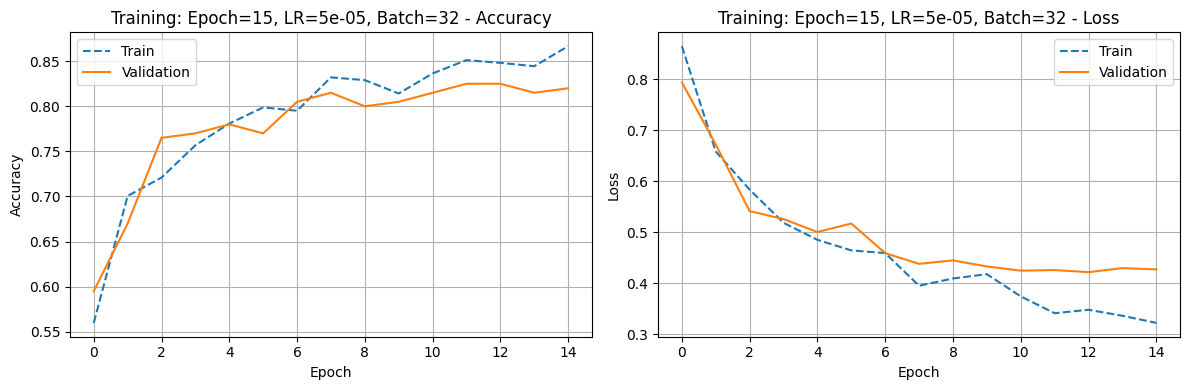

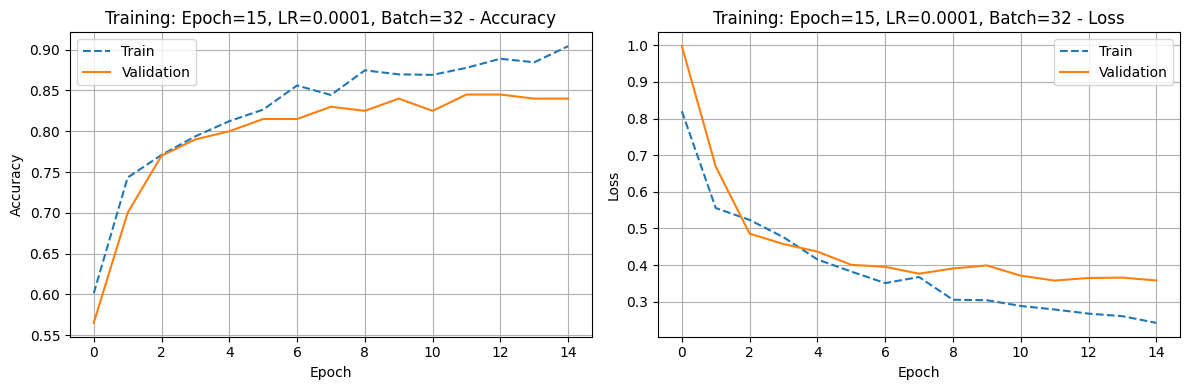

In [7]:
def plot_results_separated(results):
    for name, hist in results.items():
        plt.figure(figsize=(12, 4))

        # Accuracy plot
        plt.subplot(1, 2, 1)
        plt.plot(hist.history['accuracy'], linestyle='--', label='Train')
        plt.plot(hist.history['val_accuracy'], linestyle='-', label='Validation')
        plt.title(f"{name} - Accuracy")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.legend()
        plt.grid(True)

        # Loss plot
        plt.subplot(1, 2, 2)
        plt.plot(hist.history['loss'], linestyle='--', label='Train')
        plt.plot(hist.history['val_loss'], linestyle='-', label='Validation')
        plt.title(f"{name} - Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.grid(True)

        plt.tight_layout()
        plt.show()

plot_results_separated(results_resnet)